In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import kmapper as km
import networkx as nx
import torch 
import sklearn

from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler
from src.utils import set_random_seeds

In [2]:
set_random_seeds(3)

In [3]:
%load_ext autoreload
%autoreload 2

# Case Study - Gender bias in CelebA

In [4]:
"""
Code from Ivan's answer to
https://stackoverflow.com/questions/37921295/python-pil-image-make-3x3-grid-from-sequence-images
"""

def grid(imgs, cols, rows):

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
        
    return grid

In [5]:
root = Path("../")
data = root/"data"
celeba_folder = data/"celeba"

images_folder = celeba_folder/"img_align_celeba"

In [20]:
features = "autoencoder"
reduced_features = "{}_reduced_PCA_3".format(features)
rf_column = reduced_features + "_2023-02-06_KP"

In [21]:
female = pd.read_csv(celeba_folder/"celeba_female.csv")

female.drop(female.columns[0], axis=1, inplace=True)

female.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000004.jpg                -1               -1           1               -1   
3  000005.jpg                -1                1           1               -1   
4  000006.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Kantorovich_potential  \
0    -1     -1        -1        -1          -1  ...              -0.765183   
1    -1     -1        -1         1          -1  ...              -0.797076   
2    -1     -1        -1        -1          -1  ...              -0.825069   
3    -1     -1         1        -1          -1  ...              -0.865764   
4    -1     -1         1        -1          -1  ...              -0.814215   

   autoencoder_Kantorovich_potential  facenet_Kantorovich_potential  \
0                         701.408325                      -0.765183   
1                          86.746094                      -0.797076   
2                         176.555298                      -0.825069   
3                         131.299194                      -0.865764   
4                         437.656616                      -0.814215   

   resnet18_Kantorovich_potential  \
0                       82.637604   
1                       19.045990   
2                       26.501953   
3                       38.733154   
4                       45.056549   

   resnet18_reduced_TSNE_3_Kantorovich_potential  \
0                                     -27.609985   
1                                     -72.975426   
2                                      11.682011   
3                                     -14.109062   
4                                      10.606331   

   autoencoder_reduced_TSNE_3_Kantorovich_potential  \
0                                         -1.657837   
1                                        -26.516876   
2                                        -40.391464   
3                                        -60.763031   
4                                         17.735790   

   facenet_reduced_TSNE_3_Kantorovich_potential  \
0                                    -19.545067   
1                                   -254.932648   
2                                    -93.194344   
3                                   -179.257599   
4                                   -113.865417   

   resnet18_reduced_PCA_3_2023-02-06_KP  \
0                             21.682522   
1                            -21.291052   
2                            -19.250849   
3                             -5.770702   
4                             -3.654618   

   autoencoder_reduced_PCA_3_2023-02-06_KP  \
0                                60.510864   
1                                -9.264862   
2                               -66.910080   
3                                -8.772400   
4                                71.846268   

   facenet_reduced_PCA_3_2023-02-06_KP  
0                            -0.301837  
1                            -0.261776  
2                            -0.351014  
3                            -0.304793  
4                            -0.313966  

[5 rows x 51 columns]

In [22]:
female.sort_values(by=rf_column, ascending=False, inplace=True)

In [23]:
female[:36].head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
109914  189143.jpg                -1                1           1   
28912   049771.jpg                -1                1           1   
29016   049932.jpg                -1                1           1   
58462   100631.jpg                -1                1           1   
69219   119140.jpg                -1               -1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
109914               -1    -1     -1         1        -1           1  ...   
28912                -1    -1     -1        -1        -1           1  ...   
29016                -1    -1     -1        -1        -1           1  ...   
58462                -1    -1      1        -1        -1          -1  ...   
69219                -1    -1     -1        -1        -1           1  ...   

        Kantorovich_potential  autoencoder_Kantorovich_potential  \
109914              -0.725233                         911.297607   
28912               -0.848377                         910.965210   
29016               -0.782908                        1017.131226   
58462               -0.823223                        1061.911621   
69219               -0.799034                        1038.259521   

        facenet_Kantorovich_potential  resnet18_Kantorovich_potential  \
109914                      -0.725233                       79.363602   
28912                       -0.848377                       44.674835   
29016                       -0.782908                      116.400269   
58462                       -0.823223                       94.225693   
69219                       -0.799034                       90.205643   

        resnet18_reduced_TSNE_3_Kantorovich_potential  \
109914                                      73.929924   
28912                                      117.392395   
29016                                       55.508797   
58462                                      101.725517   
69219                                       79.680817   

        autoencoder_reduced_TSNE_3_Kantorovich_potential  \
109914                                          3.043167   
28912                                          33.274712   
29016                                          11.633425   
58462                                          42.423218   
69219                                          35.271442   

        facenet_reduced_TSNE_3_Kantorovich_potential  \
109914                                    121.240585   
28912                                     134.536713   
29016                                     220.249237   
58462                                      74.914246   
69219                                    -116.945900   

        resnet18_reduced_PCA_3_2023-02-06_KP  \
109914                             20.817940   
28912                               1.020193   
29016                              33.406883   
58462                              28.433235   
69219                              30.718699   

        autoencoder_reduced_PCA_3_2023-02-06_KP  \
109914                               449.499695   
28912                                441.118408   
29016                                430.563354   
58462                                422.901733   
69219                                421.829163   

        facenet_reduced_PCA_3_2023-02-06_KP  
109914                            -0.189394  
28912                             -0.311946  
29016                             -0.269129  
58462                             -0.274188  
69219                             -0.224873  

[5 rows x 51 columns]

In [24]:
top_images = [Image.open(images_folder/file) for file in female[:18].image_id]
bottom_images = [Image.open(images_folder/file) for file in female[-18:].image_id]

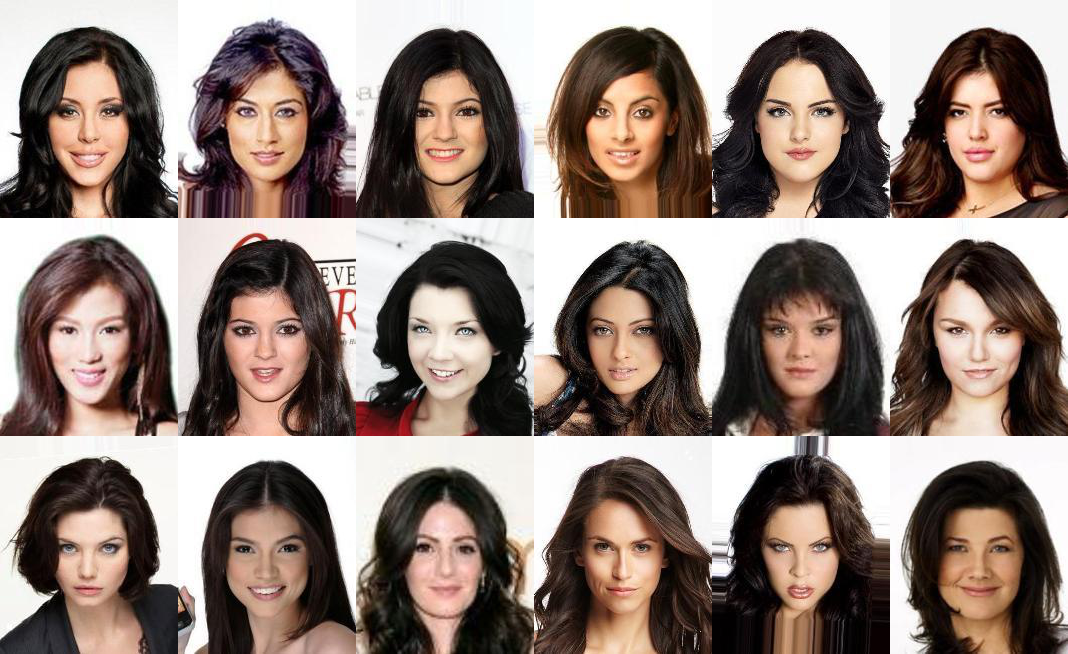

In [25]:
top_grid = grid(top_images, 6, 3)

top_grid.save(root/"results/Experiment5/top18_female_red_{}.png".format(features))
display(top_grid)

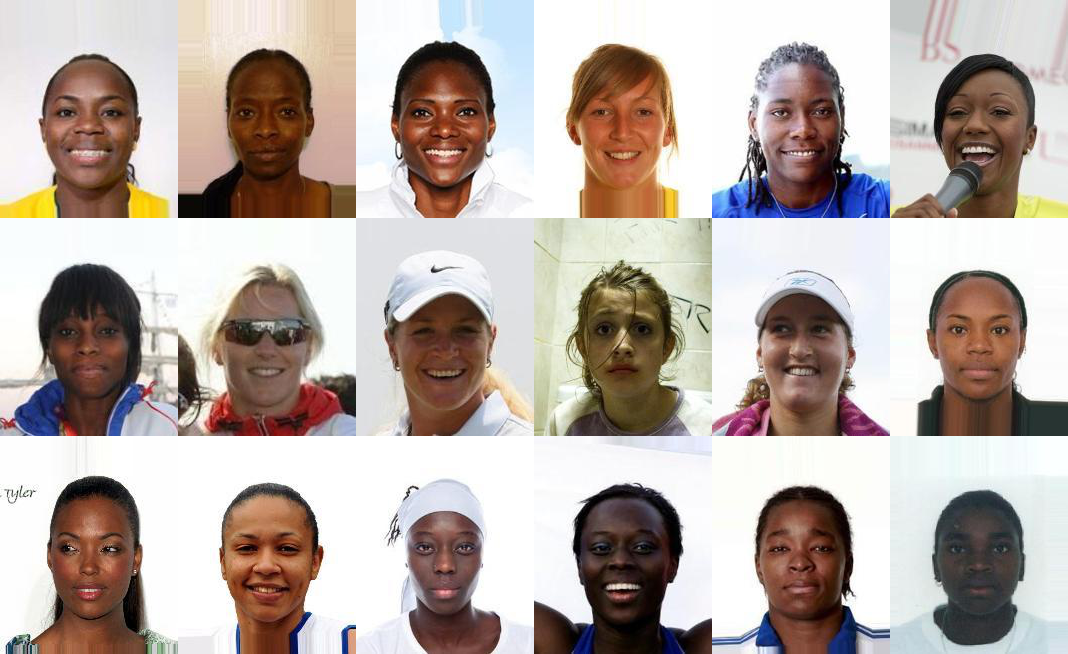

In [26]:
bottom_grid = grid(bottom_images, 6, 3)

bottom_grid.save(root/"results/Experiment5/bottom18_female_red_{}.png".format(features))
display(bottom_grid)

In [13]:
def open_array(path):
    tensor = torch.load(path)
    
    return tensor.detach().numpy()

data = np.concatenate([open_array(celeba_folder/reduced_features/"{}.pt".format(file[:-4])) for file in female.image_id])

In [14]:
projected_data = np.array(female[rf_column])

In [15]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data)

In [16]:
mapper = km.KeplerMapper(verbose=2)

KeplerMapper(verbose=2)


In [17]:
projected_data = projected_data.reshape(-1,1)

In [18]:
cover = km.Cover(n_cubes=6, perc_overlap=0.1)

In [19]:
graph = mapper.map(projected_data, scaled_data, cover=cover, clusterer=sklearn.cluster.KMeans(1) )

Mapping on data shaped (118165, 3) using lens shaped (118165, 1)

Minimal points in hypercube before clustering: 1
Creating 6 hypercubes.
   > Found 1 clusters in hypercube 0.
   > Found 1 clusters in hypercube 1.
   > Found 1 clusters in hypercube 2.
   > Found 1 clusters in hypercube 3.
   > Found 1 clusters in hypercube 4.
   > Found 1 clusters in hypercube 5.

Created 5 edges and 6 nodes in 0:00:00.734296.


In [20]:
graph.keys()

dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes'])

In [21]:
preimages = [scaled_data[graph["nodes"][cluster]] for cluster in graph["nodes"]]

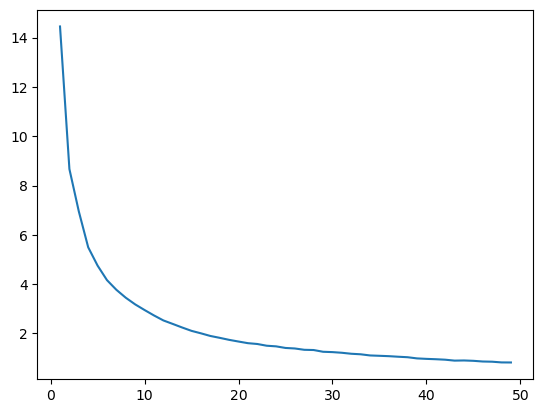

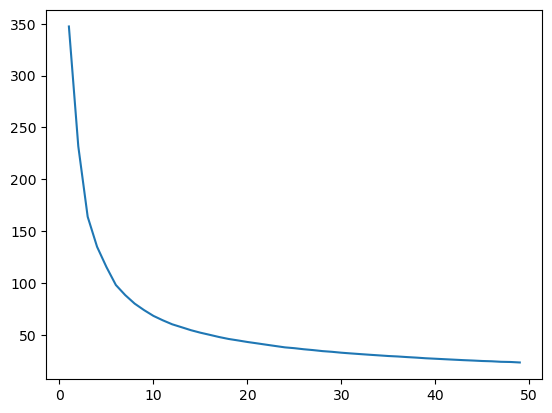

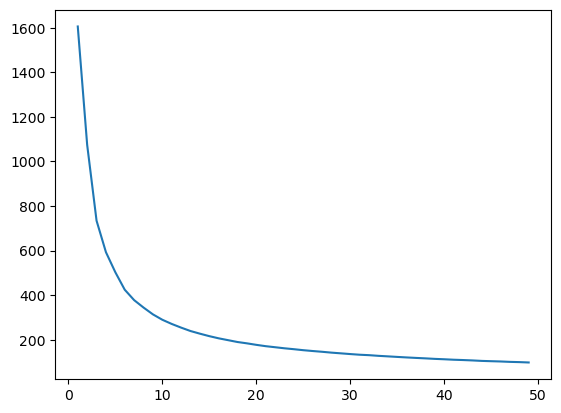

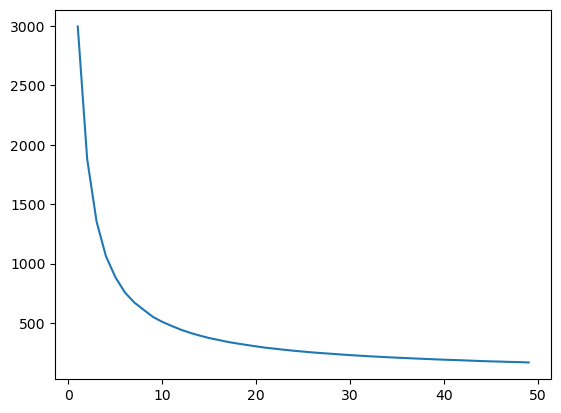

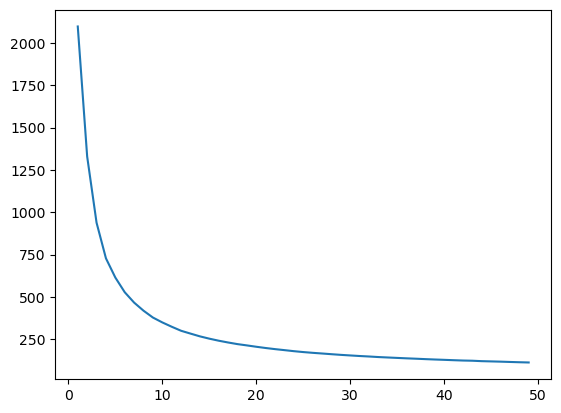

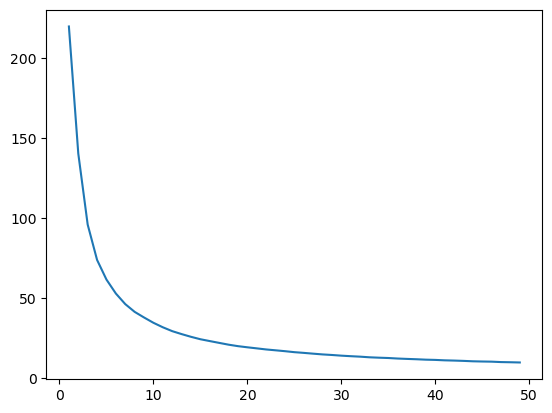

In [22]:
for pi in preimages:
    sse = list()
    n = min(50, pi.shape[0])
    for k in range(1, n):
        kmeans = sklearn.cluster.KMeans(k)
        kmeans.fit(pi)
        sse.append(kmeans.inertia_)
        
    plt.plot(np.arange(1,n),sse)
    plt.show()

In [23]:
graph = mapper.map(projected_data, scaled_data, cover=cover, clusterer=sklearn.cluster.KMeans(10))

Mapping on data shaped (118165, 3) using lens shaped (118165, 1)

Minimal points in hypercube before clustering: 10
Creating 6 hypercubes.
   > Found 10 clusters in hypercube 0.
   > Found 10 clusters in hypercube 1.
   > Found 10 clusters in hypercube 2.
   > Found 10 clusters in hypercube 3.
   > Found 10 clusters in hypercube 4.
   > Found 10 clusters in hypercube 5.

Created 154 edges and 60 nodes in 0:00:06.636300.


In [24]:
g = nx.Graph()

In [25]:
g.add_nodes_from(graph["nodes"])

for node in g.nodes(data=True):
    node[1]["cube"] = node[0][4]
    node[1]["size"] = len(graph["nodes"][node[0]])
    node[1]["subset"] = node[0][4]

In [26]:
for u, vs in graph["links"].items():
    for v in vs:
        g.add_edge(u,v)

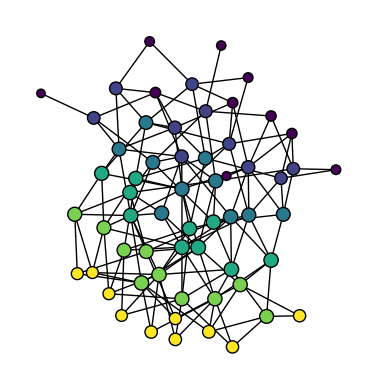

In [27]:
"""
code from kepler-mapper documentation: 
https://kepler-mapper.scikit-tda.org/en/latest/_modules/kmapper/drawing.html#draw_matplotlib
"""
fig = plt.figure()
ax = plt.gca()

bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
area = width * height * fig.dpi

n_nodes = len(g.nodes)

# size of node should be related to area and number of nodes -- heuristic
node_size = np.pi * area / n_nodes
node_r = np.sqrt(node_size / np.pi)
node_edge = node_r / 3

#pos = nx.multipartite_layout(g, "cube", "horizontal")
#pos = nx.spring_layout(g, k=.2)
pos = nx.kamada_kawai_layout(g)
node_color = [int(n[1]["cube"]) for n in g.nodes(data=True)]
node_size = [1.3*node_size*np.log(n[1]["size"])/10 for n in g.nodes(data=True)]

nodes = nx.draw_networkx_nodes(g, node_color = node_color, node_size=node_size, pos=pos, ax=ax, cmap = plt.cm.viridis)
edges = nx.draw_networkx_edges(g, pos=pos, ax=ax)
nodes.set_edgecolor("black")
edges.set_linewidth(1)
edges.set_edgecolor("black")

ax.axis("square")
ax.axis("off")

path = root/"results"/"Experiment5"/"graph_{}.pdf".format(reduced_features)
#plt.savefig(path)
plt.show()

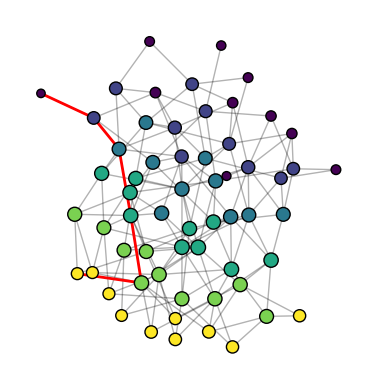

In [28]:
fig = plt.figure()
ax = plt.gca()
cluster1, cluster2 = "cube0_cluster5", "cube5_cluster5"
shortest_path = nx.shortest_path(g, cluster1, cluster2)

nodes = nx.draw_networkx_nodes(g,
                               node_color = node_color,
                               node_size=node_size,
                               pos=pos,
                               ax=ax,
                               cmap = plt.cm.viridis,
                              alpha=1)
edges = nx.draw_networkx_edges(g, pos=pos, ax=ax, alpha=0.3)
nodes.set_edgecolor("black")
edges.set_linewidth(1)
edges.set_edgecolor("black")

edges_r = nx.draw_networkx_edges(g.subgraph(shortest_path), pos=pos, ax=ax)
edges_r.set_linewidth(2)
edges_r.set_edgecolor("r")

ax.axis("square")
ax.axis("off")


path = root/"results"/"Experiment5"/"graph_{}_path_{}_{}.pdf".format(reduced_features, cluster1, cluster2)
plt.savefig(path)
plt.show()

cube0_cluster5


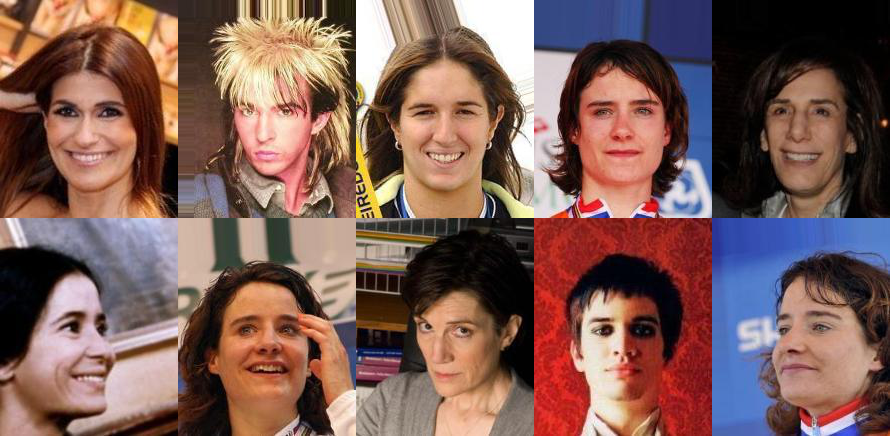

cube1_cluster0


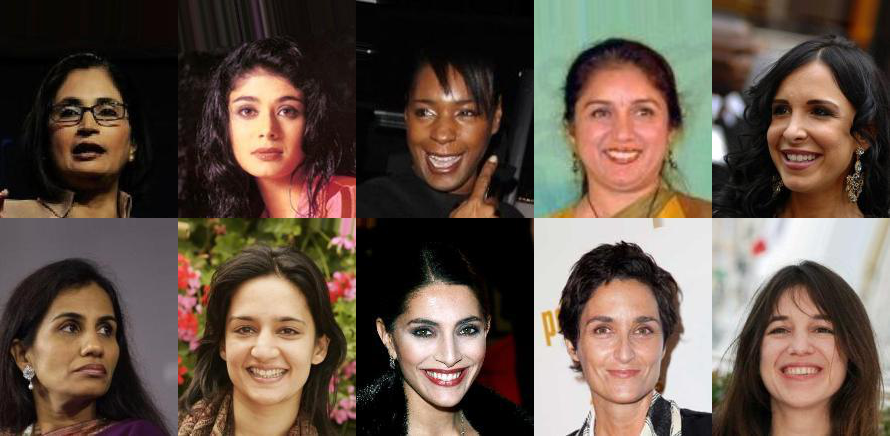

cube2_cluster5


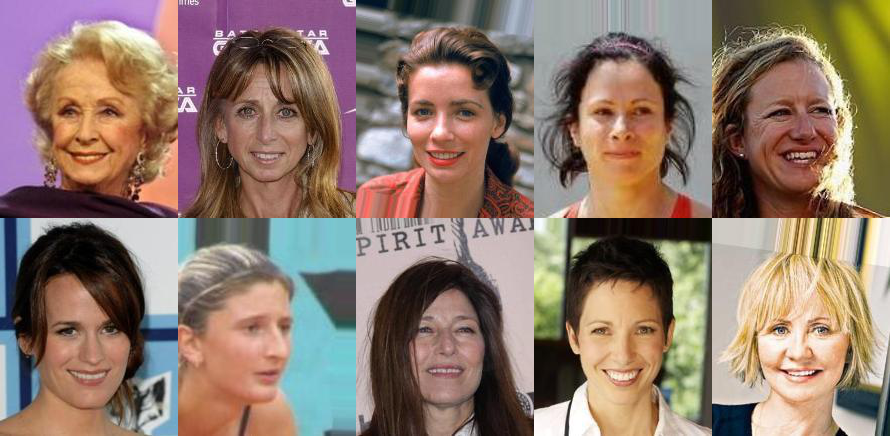

cube3_cluster1


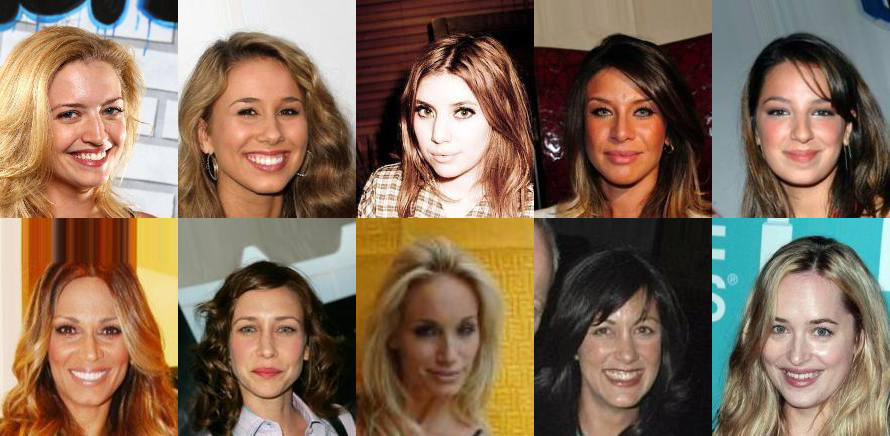

cube4_cluster2


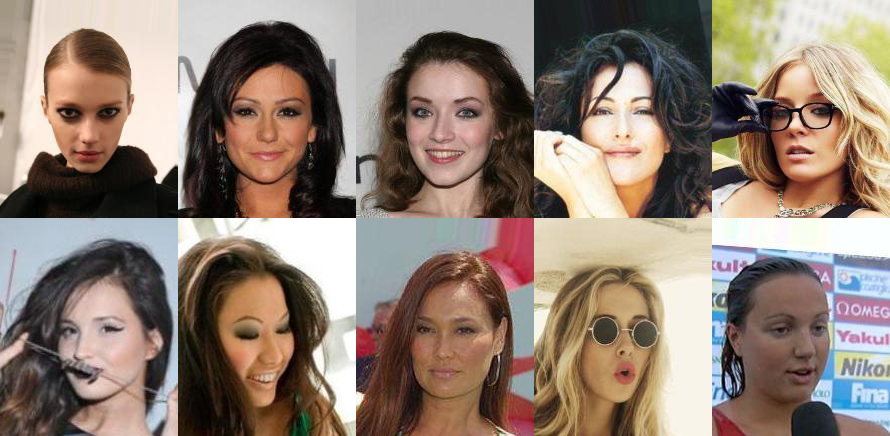

cube5_cluster5


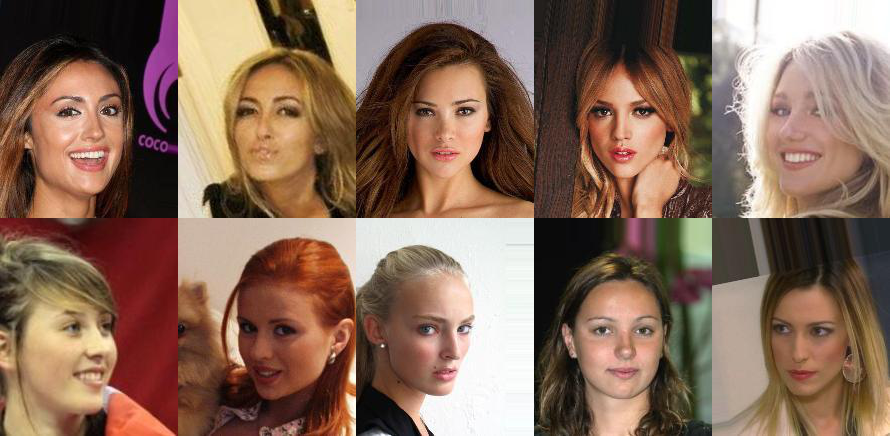

In [29]:
for cluster in shortest_path:
    points = graph["nodes"][cluster]
    
    if data[points].shape[0] >= 10:
        images = [Image.open(images_folder/file) for file in female.reset_index().loc[points, "image_id"].sample(10)]

        grid_im = grid(images, 5,2)
        print(cluster)
        display(grid_im)
    
    else:
        images = [Image.open(images_folder/file) for file in female.reset_index().loc[points, "image_id"].sample(data[points].shape[0])]

        grid_im = grid(images, data[points].shape[0]//2 , 2)
        print(cluster)
        display(grid_im)
        
    path = root/"results"/"Experiment5"/"{}_{}.pdf".format(reduced_features, cluster) 
    grid_im.save(path)
    